Initial Analysis: Missing Data & Duplicates

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (assuming it's named 'creditcard.csv')
df = pd.read_csv('/content/drive/MyDrive/machine learning/creditcard.csv')

# 1. Finding Missing Data
print("--- Missing Values Per Column ---")
print(df.isnull().sum())

# 2. Finding Duplicates
duplicates = df.duplicated().sum()
print(f"\nTotal duplicate rows found: {duplicates}")

# Optional: Remove duplicates if they exist
if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicates removed.")

--- Missing Values Per Column ---
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Total duplicate rows found: 1081
Duplicates removed.


Checking the Class Balance


--- Class Distribution ---
Class
0    283253
1       473
Name: count, dtype: int64


/tmp/ipython-input-1501186602.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


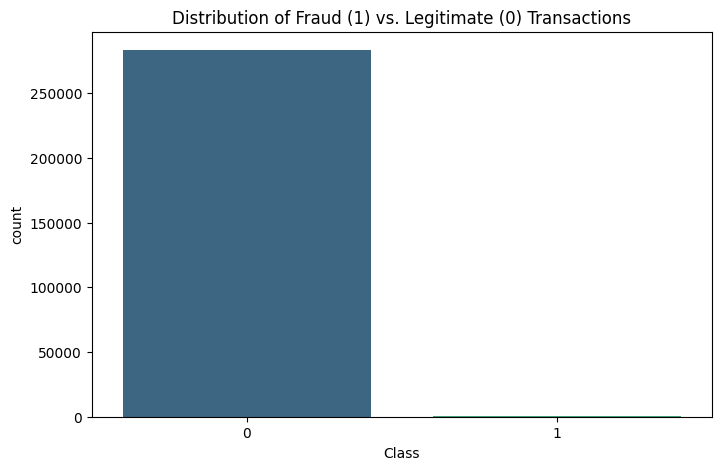

Percentage of Fraudulent Transactions: 0.167%


In [10]:
# 3. Balancing between Fraud and Not Fraud
print("\n--- Class Distribution ---")
print(df['Class'].value_counts())

# Visualize the imbalance
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', data=df, palette='viridis')
plt.title('Distribution of Fraud (1) vs. Legitimate (0) Transactions')
plt.show()

# Percentage calculation
fraud_pct = (df['Class'].value_counts()[1] / len(df)) * 100
print(f"Percentage of Fraudulent Transactions: {fraud_pct:.3f}%")

Correlation Heatmap

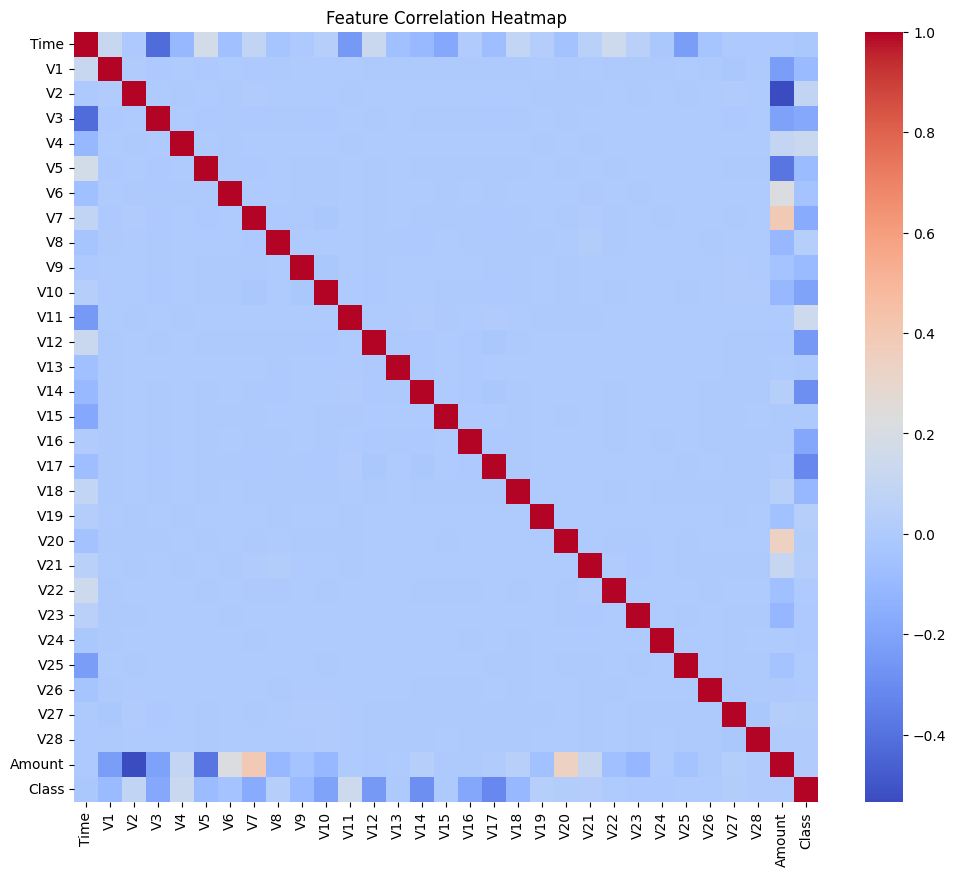


--- Correlation of Features with Fraud ---
Class     1.000000
V11       0.149067
V4        0.129326
V2        0.084624
V19       0.033631
V8        0.033068
V21       0.026357
V27       0.021892
V20       0.021486
V28       0.009682
Amount    0.005777
V22       0.004887
V26       0.004265
V25       0.003202
V15      -0.003300
V13      -0.003897
V23      -0.006333
V24      -0.007210
Time     -0.012359
V6       -0.043915
V5       -0.087812
V9       -0.094021
V1       -0.094486
V18      -0.105340
V7       -0.172347
V3       -0.182322
V16      -0.187186
V10      -0.206971
V12      -0.250711
V14      -0.293375
V17      -0.313498
Name: Class, dtype: float64


In [11]:
# 4. Correlation Graph
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

# Specific correlation with the target 'Class'
print("\n--- Correlation of Features with Fraud ---")
print(correlation_matrix['Class'].sort_values(ascending=False))

Feature Engineering with V17

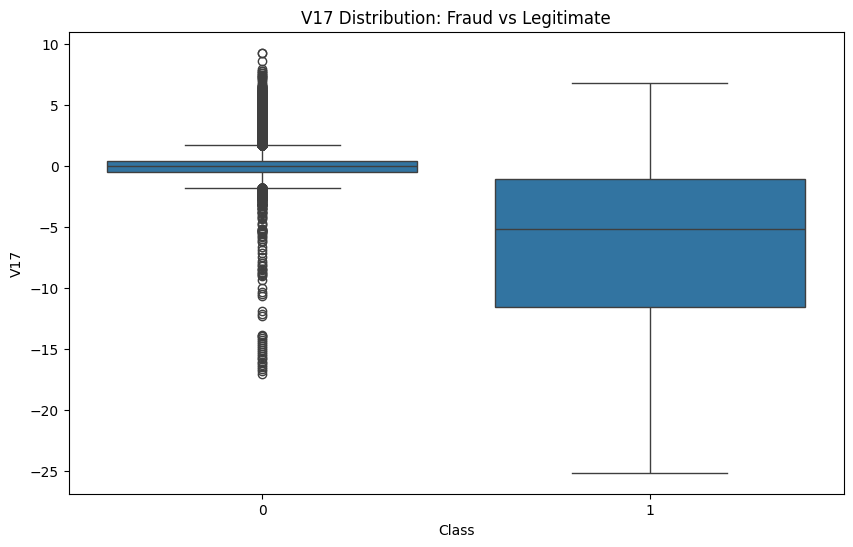

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing the distribution of V17
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='V17', data=df)
plt.title('V17 Distribution: Fraud vs Legitimate')
plt.show()

Over-sampling (SMOTE)

In [13]:
# You may need to install the library first:
# !pip install imbalanced-learn

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Separate Features and Target
X = df.drop('Class', axis=1)
y = df['Class']

# 2. Split into Training and Testing sets (80/20)
# Use 'stratify=y' to ensure both sets have the same percentage of fraud
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Before SMOTE - Fraud cases in training: {sum(y_train == 1)}")
print(f"Before SMOTE - Legitimate cases in training: {sum(y_train == 0)}")

# 3. Apply SMOTE only to the TRAINING data
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE - Fraud cases in training: {sum(y_train_res == 1)}")
print(f"After SMOTE - Legitimate cases in training: {sum(y_train_res == 0)}")

# Now you use X_train_res and y_train_res to train your model!

Before SMOTE - Fraud cases in training: 378
Before SMOTE - Legitimate cases in training: 226602

After SMOTE - Fraud cases in training: 226602
After SMOTE - Legitimate cases in training: 226602


Training with SMOTE

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the Random Forest
# n_estimators=100 is a good starting point for accuracy and speed
rfc = RandomForestClassifier(n_estimators=100, random_state=42,max_depth=10, n_jobs=-1)

# Train the model on the BALANCED training data
rfc.fit(X_train_res, y_train_res)

# Predict on the ORIGINAL (Imbalanced) test data
# This ensures we are testing against real-world scenarios
y_pred = rfc.predict(X_test)

Validating the Results

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.60      0.81      0.69        95

    accuracy                           1.00     56746
   macro avg       0.80      0.90      0.84     56746
weighted avg       1.00      1.00      1.00     56746



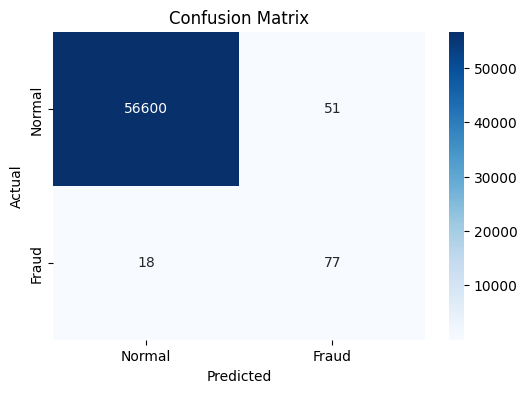

In [15]:
# Print Evaluation Metrics
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
import joblib

# Save the trained model to a file
joblib.dump(rfc, 'credit_card_fraud_model.pkl')

print("Model saved successfully as 'credit_card_fraud_model.pkl'")

Model saved successfully as 'credit_card_fraud_model.pkl'


In [17]:
import joblib

# Load the model back into memory
loaded_model = joblib.load('credit_card_fraud_model.pkl')

# Test it immediately to make sure it still works
# (Assuming X_test is already in your environment)
result = loaded_model.score(X_test, y_test)
print(f"Loaded model Accuracy: {result:.4f}")

Loaded model Accuracy: 0.9988
